In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()
from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Spice.Netlist import Circuit,SubCircuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Unit import *
from PySpice.Probe.Plot import plot
from PySpice.Logging.Logging import setup_logging
from multiprocessing import Pool
from PySpice.Spice.NgSpice.Shared import NgSpiceShared
import random
setup_logging()

libraries_path = find_libraries()
spice_library = SpiceLibrary(libraries_path)

In [2]:
def generate_mn_range(M_start, M_end, N_start, N_end):
    special_mn = []
    for m in range(M_start, M_end+1):
        for n in range(N_start, N_end+1):
            special_mn.append((m, n))
    return special_mn

In [3]:
M = 364
N = 91
w = 0.0025
l = 0.0025

In [4]:
def create_tandem_array(M, N, special_mn):
    circuit = Circuit('Perovskite/Silicon Tandem Equivalent Circuit')
    
    circuit.model('D1_top', 'D', IS = 8.8e-23*(w*l), N =1)
    circuit.model('D2_top', 'D', IS = 2.62e-13*(w*l), N =2)
    circuit.model('D1_bot', 'D', IS=1.3339e-14*(w*l), N =1)
    circuit.model('D2_bot', 'D', IS=6.5674e-19*(w*l), N =2)
    circuit.V('1', 'input', circuit.gnd, 0@u_V)

    for m in range(M):
        for n in range(N):
            name_prefix = f"{m:03d}{n:03d}"
            is_special = (m, n) in special_mn
            print(f"Processing m={m}, n={n}, is_special={is_special}")
            
            # Metal Sheet Resistance
            if m == 0:
                circuit.R(f'Metal_sheet_input{n:03d}', 'input', f'q{m:03d}{n:03d}', 2.13*l/w@u_mOhm)
            if ( m == 1 and 0 < n < 91) or (m > 1 and  n == 45):
                circuit.R(f'Metal_sheet_v{m:03d}{n:03d}', f'q{m-1:03d}{n:03d}', f'q{m:03d}{n:03d}', 2.13*l/w@u_mOhm)
                circuit.R(f'Metal_sheet_h{m:03d}{n:03d}', f'q{m:03d}{n-1:03d}', f'q{m:03d}{n:03d}', 2.13*w/l@u_mOhm)
                circuit.R(f'c_metal_{name_prefix}', f'q{m:03d}{n:03d}', f'a{m:03d}{n:03d}', 5/(w*l)@u_mOhm)            
            
                
            # ITO Sheet Resistance
            
            if m > 0:
                circuit.R(f'ITO_sheet_v{m:03d}{n:03d}', f'a{m-1:03d}{n:03d}', f'a{m:03d}{n:03d}', 55*l/w@u_Ohm)
            if n > 0:
                circuit.R(f'ITO_sheet_h{m:03d}{n:03d}', f'a{m:03d}{n-1:03d}', f'a{m:03d}{n:03d}', 55*w/l@u_Ohm)

            # RJ Sheet Resistance
            if m > 0:
                circuit.R(f'RJ_sheet_v{m:03d}{n:03d}', f'd{m-1:03d}{n:02d}', f'd{m:03d}{n:03d}', 200*l/w@u_Ohm)
            if n > 0:
                circuit.R(f'RJ_sheet_h{m:03d}{n:03d}', f'd{m:03d}{n-1:03d}', f'd{m:03d}{n:03d}', 200*w/l@u_Ohm)

            # Top Cell
            
            circuit.R(f's_top_{name_prefix}', f'a{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 2/(w*l)@u_Ohm)
            circuit.D(f'1_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', model='D1_top')
            circuit.D(f'2_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', model='D2_top')
            if is_special:
                circuit.R(f'sh_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', 2/(w*l)@u_Ohm)
                
            else:
                circuit.R(f'sh_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', 5.55/(w*l)@u_kOhm)
                
            if (m < 2 and n < 91) or (m > 1 and  n == 45):
                circuit.I(f'ph_top_{name_prefix}', f'c{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 0*(w*l)@u_mA)
            else:
                circuit.I(f'ph_top_{name_prefix}', f'c{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 19.65*(w*l)@u_mA)

            # Connection
            circuit.R(f'c_top_{name_prefix}', f'c{m:03d}{n:03d}', f'd{m:03d}{n:03d}', 0/(w*l)@u_mOhm)
            circuit.R(f'c_bot_{name_prefix}', f'd{m:03d}{n:03d}', f'e{m:03d}{n:03d}', 0/(w*l)@u_mOhm)

            # Bottom Cell
            circuit.R(f's_bot_{name_prefix}', f'e{m:03d}{n:03d}', f'f{m:03d}{n:03d}', 0.2/(w*l)@u_Ohm)
            circuit.D(f'1_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, model='D1_bot')
            circuit.D(f'2_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, model='D2_bot')
            circuit.R(f'sh_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, 12/(w*l)@u_kOhm)
            if (m < 2 and n < 91) or (m > 1 and  n == 45):
                circuit.I(f'ph_bot_{name_prefix}', circuit.gnd, f'f{m:03d}{n:03d}', 0*(w*l)@u_mA)
            else:
                circuit.I(f'ph_bot_{name_prefix}', circuit.gnd, f'f{m:03d}{n:03d}', 19.65*(w*l)@u_mA)

    return circuit

In [5]:
M_start = 175
M_end = 189
N_start = 45
N_end = 59
special_mn = generate_mn_range(M_start, M_end, N_start, N_end)
circuit = create_tandem_array(M, N, special_mn)

Processing m=0, n=0, is_special=False
Processing m=0, n=1, is_special=False
Processing m=0, n=2, is_special=False
Processing m=0, n=3, is_special=False
Processing m=0, n=4, is_special=False
Processing m=0, n=5, is_special=False
Processing m=0, n=6, is_special=False
Processing m=0, n=7, is_special=False
Processing m=0, n=8, is_special=False
Processing m=0, n=9, is_special=False
Processing m=0, n=10, is_special=False
Processing m=0, n=11, is_special=False
Processing m=0, n=12, is_special=False
Processing m=0, n=13, is_special=False
Processing m=0, n=14, is_special=False
Processing m=0, n=15, is_special=False
Processing m=0, n=16, is_special=False
Processing m=0, n=17, is_special=False
Processing m=0, n=18, is_special=False
Processing m=0, n=19, is_special=False
Processing m=0, n=20, is_special=False
Processing m=0, n=21, is_special=False
Processing m=0, n=22, is_special=False
Processing m=0, n=23, is_special=False
Processing m=0, n=24, is_special=False
Processing m=0, n=25, is_special=Fa

Processing m=14, n=40, is_special=False
Processing m=14, n=41, is_special=False
Processing m=14, n=42, is_special=False
Processing m=14, n=43, is_special=False
Processing m=14, n=44, is_special=False
Processing m=14, n=45, is_special=False
Processing m=14, n=46, is_special=False
Processing m=14, n=47, is_special=False
Processing m=14, n=48, is_special=False
Processing m=14, n=49, is_special=False
Processing m=14, n=50, is_special=False
Processing m=14, n=51, is_special=False
Processing m=14, n=52, is_special=False
Processing m=14, n=53, is_special=False
Processing m=14, n=54, is_special=False
Processing m=14, n=55, is_special=False
Processing m=14, n=56, is_special=False
Processing m=14, n=57, is_special=False
Processing m=14, n=58, is_special=False
Processing m=14, n=59, is_special=False
Processing m=14, n=60, is_special=False
Processing m=14, n=61, is_special=False
Processing m=14, n=62, is_special=False
Processing m=14, n=63, is_special=False
Processing m=14, n=64, is_special=False


Processing m=28, n=42, is_special=False
Processing m=28, n=43, is_special=False
Processing m=28, n=44, is_special=False
Processing m=28, n=45, is_special=False
Processing m=28, n=46, is_special=False
Processing m=28, n=47, is_special=False
Processing m=28, n=48, is_special=False
Processing m=28, n=49, is_special=False
Processing m=28, n=50, is_special=False
Processing m=28, n=51, is_special=False
Processing m=28, n=52, is_special=False
Processing m=28, n=53, is_special=False
Processing m=28, n=54, is_special=False
Processing m=28, n=55, is_special=False
Processing m=28, n=56, is_special=False
Processing m=28, n=57, is_special=False
Processing m=28, n=58, is_special=False
Processing m=28, n=59, is_special=False
Processing m=28, n=60, is_special=False
Processing m=28, n=61, is_special=False
Processing m=28, n=62, is_special=False
Processing m=28, n=63, is_special=False
Processing m=28, n=64, is_special=False
Processing m=28, n=65, is_special=False
Processing m=28, n=66, is_special=False


Processing m=39, n=54, is_special=False
Processing m=39, n=55, is_special=False
Processing m=39, n=56, is_special=False
Processing m=39, n=57, is_special=False
Processing m=39, n=58, is_special=False
Processing m=39, n=59, is_special=False
Processing m=39, n=60, is_special=False
Processing m=39, n=61, is_special=False
Processing m=39, n=62, is_special=False
Processing m=39, n=63, is_special=False
Processing m=39, n=64, is_special=False
Processing m=39, n=65, is_special=False
Processing m=39, n=66, is_special=False
Processing m=39, n=67, is_special=False
Processing m=39, n=68, is_special=False
Processing m=39, n=69, is_special=False
Processing m=39, n=70, is_special=False
Processing m=39, n=71, is_special=False
Processing m=39, n=72, is_special=False
Processing m=39, n=73, is_special=False
Processing m=39, n=74, is_special=False
Processing m=39, n=75, is_special=False
Processing m=39, n=76, is_special=False
Processing m=39, n=77, is_special=False
Processing m=39, n=78, is_special=False


Processing m=51, n=82, is_special=False
Processing m=51, n=83, is_special=False
Processing m=51, n=84, is_special=False
Processing m=51, n=85, is_special=False
Processing m=51, n=86, is_special=False
Processing m=51, n=87, is_special=False
Processing m=51, n=88, is_special=False
Processing m=51, n=89, is_special=False
Processing m=51, n=90, is_special=False
Processing m=52, n=0, is_special=False
Processing m=52, n=1, is_special=False
Processing m=52, n=2, is_special=False
Processing m=52, n=3, is_special=False
Processing m=52, n=4, is_special=False
Processing m=52, n=5, is_special=False
Processing m=52, n=6, is_special=False
Processing m=52, n=7, is_special=False
Processing m=52, n=8, is_special=False
Processing m=52, n=9, is_special=False
Processing m=52, n=10, is_special=False
Processing m=52, n=11, is_special=False
Processing m=52, n=12, is_special=False
Processing m=52, n=13, is_special=False
Processing m=52, n=14, is_special=False
Processing m=52, n=15, is_special=False
Processing

Processing m=67, n=64, is_special=False
Processing m=67, n=65, is_special=False
Processing m=67, n=66, is_special=False
Processing m=67, n=67, is_special=False
Processing m=67, n=68, is_special=False
Processing m=67, n=69, is_special=False
Processing m=67, n=70, is_special=False
Processing m=67, n=71, is_special=False
Processing m=67, n=72, is_special=False
Processing m=67, n=73, is_special=False
Processing m=67, n=74, is_special=False
Processing m=67, n=75, is_special=False
Processing m=67, n=76, is_special=False
Processing m=67, n=77, is_special=False
Processing m=67, n=78, is_special=False
Processing m=67, n=79, is_special=False
Processing m=67, n=80, is_special=False
Processing m=67, n=81, is_special=False
Processing m=67, n=82, is_special=False
Processing m=67, n=83, is_special=False
Processing m=67, n=84, is_special=False
Processing m=67, n=85, is_special=False
Processing m=67, n=86, is_special=False
Processing m=67, n=87, is_special=False
Processing m=67, n=88, is_special=False


Processing m=85, n=46, is_special=False
Processing m=85, n=47, is_special=False
Processing m=85, n=48, is_special=False
Processing m=85, n=49, is_special=False
Processing m=85, n=50, is_special=False
Processing m=85, n=51, is_special=False
Processing m=85, n=52, is_special=False
Processing m=85, n=53, is_special=False
Processing m=85, n=54, is_special=False
Processing m=85, n=55, is_special=False
Processing m=85, n=56, is_special=False
Processing m=85, n=57, is_special=False
Processing m=85, n=58, is_special=False
Processing m=85, n=59, is_special=False
Processing m=85, n=60, is_special=False
Processing m=85, n=61, is_special=False
Processing m=85, n=62, is_special=False
Processing m=85, n=63, is_special=False
Processing m=85, n=64, is_special=False
Processing m=85, n=65, is_special=False
Processing m=85, n=66, is_special=False
Processing m=85, n=67, is_special=False
Processing m=85, n=68, is_special=False
Processing m=85, n=69, is_special=False
Processing m=85, n=70, is_special=False


Processing m=111, n=52, is_special=False
Processing m=111, n=53, is_special=False
Processing m=111, n=54, is_special=False
Processing m=111, n=55, is_special=False
Processing m=111, n=56, is_special=False
Processing m=111, n=57, is_special=False
Processing m=111, n=58, is_special=False
Processing m=111, n=59, is_special=False
Processing m=111, n=60, is_special=False
Processing m=111, n=61, is_special=False
Processing m=111, n=62, is_special=False
Processing m=111, n=63, is_special=False
Processing m=111, n=64, is_special=False
Processing m=111, n=65, is_special=False
Processing m=111, n=66, is_special=False
Processing m=111, n=67, is_special=False
Processing m=111, n=68, is_special=False
Processing m=111, n=69, is_special=False
Processing m=111, n=70, is_special=False
Processing m=111, n=71, is_special=False
Processing m=111, n=72, is_special=False
Processing m=111, n=73, is_special=False
Processing m=111, n=74, is_special=False
Processing m=111, n=75, is_special=False
Processing m=111

Processing m=127, n=85, is_special=False
Processing m=127, n=86, is_special=False
Processing m=127, n=87, is_special=False
Processing m=127, n=88, is_special=False
Processing m=127, n=89, is_special=False
Processing m=127, n=90, is_special=False
Processing m=128, n=0, is_special=False
Processing m=128, n=1, is_special=False
Processing m=128, n=2, is_special=False
Processing m=128, n=3, is_special=False
Processing m=128, n=4, is_special=False
Processing m=128, n=5, is_special=False
Processing m=128, n=6, is_special=False
Processing m=128, n=7, is_special=False
Processing m=128, n=8, is_special=False
Processing m=128, n=9, is_special=False
Processing m=128, n=10, is_special=False
Processing m=128, n=11, is_special=False
Processing m=128, n=12, is_special=False
Processing m=128, n=13, is_special=False
Processing m=128, n=14, is_special=False
Processing m=128, n=15, is_special=False
Processing m=128, n=16, is_special=False
Processing m=128, n=17, is_special=False
Processing m=128, n=18, is

Processing m=141, n=88, is_special=False
Processing m=141, n=89, is_special=False
Processing m=141, n=90, is_special=False
Processing m=142, n=0, is_special=False
Processing m=142, n=1, is_special=False
Processing m=142, n=2, is_special=False
Processing m=142, n=3, is_special=False
Processing m=142, n=4, is_special=False
Processing m=142, n=5, is_special=False
Processing m=142, n=6, is_special=False
Processing m=142, n=7, is_special=False
Processing m=142, n=8, is_special=False
Processing m=142, n=9, is_special=False
Processing m=142, n=10, is_special=False
Processing m=142, n=11, is_special=False
Processing m=142, n=12, is_special=False
Processing m=142, n=13, is_special=False
Processing m=142, n=14, is_special=False
Processing m=142, n=15, is_special=False
Processing m=142, n=16, is_special=False
Processing m=142, n=17, is_special=False
Processing m=142, n=18, is_special=False
Processing m=142, n=19, is_special=False
Processing m=142, n=20, is_special=False
Processing m=142, n=21, is

Processing m=160, n=23, is_special=False
Processing m=160, n=24, is_special=False
Processing m=160, n=25, is_special=False
Processing m=160, n=26, is_special=False
Processing m=160, n=27, is_special=False
Processing m=160, n=28, is_special=False
Processing m=160, n=29, is_special=False
Processing m=160, n=30, is_special=False
Processing m=160, n=31, is_special=False
Processing m=160, n=32, is_special=False
Processing m=160, n=33, is_special=False
Processing m=160, n=34, is_special=False
Processing m=160, n=35, is_special=False
Processing m=160, n=36, is_special=False
Processing m=160, n=37, is_special=False
Processing m=160, n=38, is_special=False
Processing m=160, n=39, is_special=False
Processing m=160, n=40, is_special=False
Processing m=160, n=41, is_special=False
Processing m=160, n=42, is_special=False
Processing m=160, n=43, is_special=False
Processing m=160, n=44, is_special=False
Processing m=160, n=45, is_special=False
Processing m=160, n=46, is_special=False
Processing m=160

Processing m=175, n=84, is_special=False
Processing m=175, n=85, is_special=False
Processing m=175, n=86, is_special=False
Processing m=175, n=87, is_special=False
Processing m=175, n=88, is_special=False
Processing m=175, n=89, is_special=False
Processing m=175, n=90, is_special=False
Processing m=176, n=0, is_special=False
Processing m=176, n=1, is_special=False
Processing m=176, n=2, is_special=False
Processing m=176, n=3, is_special=False
Processing m=176, n=4, is_special=False
Processing m=176, n=5, is_special=False
Processing m=176, n=6, is_special=False
Processing m=176, n=7, is_special=False
Processing m=176, n=8, is_special=False
Processing m=176, n=9, is_special=False
Processing m=176, n=10, is_special=False
Processing m=176, n=11, is_special=False
Processing m=176, n=12, is_special=False
Processing m=176, n=13, is_special=False
Processing m=176, n=14, is_special=False
Processing m=176, n=15, is_special=False
Processing m=176, n=16, is_special=False
Processing m=176, n=17, is

Processing m=179, n=87, is_special=False
Processing m=179, n=88, is_special=False
Processing m=179, n=89, is_special=False
Processing m=179, n=90, is_special=False
Processing m=180, n=0, is_special=False
Processing m=180, n=1, is_special=False
Processing m=180, n=2, is_special=False
Processing m=180, n=3, is_special=False
Processing m=180, n=4, is_special=False
Processing m=180, n=5, is_special=False
Processing m=180, n=6, is_special=False
Processing m=180, n=7, is_special=False
Processing m=180, n=8, is_special=False
Processing m=180, n=9, is_special=False
Processing m=180, n=10, is_special=False
Processing m=180, n=11, is_special=False
Processing m=180, n=12, is_special=False
Processing m=180, n=13, is_special=False
Processing m=180, n=14, is_special=False
Processing m=180, n=15, is_special=False
Processing m=180, n=16, is_special=False
Processing m=180, n=17, is_special=False
Processing m=180, n=18, is_special=False
Processing m=180, n=19, is_special=False
Processing m=180, n=20, is

Processing m=196, n=36, is_special=False
Processing m=196, n=37, is_special=False
Processing m=196, n=38, is_special=False
Processing m=196, n=39, is_special=False
Processing m=196, n=40, is_special=False
Processing m=196, n=41, is_special=False
Processing m=196, n=42, is_special=False
Processing m=196, n=43, is_special=False
Processing m=196, n=44, is_special=False
Processing m=196, n=45, is_special=False
Processing m=196, n=46, is_special=False
Processing m=196, n=47, is_special=False
Processing m=196, n=48, is_special=False
Processing m=196, n=49, is_special=False
Processing m=196, n=50, is_special=False
Processing m=196, n=51, is_special=False
Processing m=196, n=52, is_special=False
Processing m=196, n=53, is_special=False
Processing m=196, n=54, is_special=False
Processing m=196, n=55, is_special=False
Processing m=196, n=56, is_special=False
Processing m=196, n=57, is_special=False
Processing m=196, n=58, is_special=False
Processing m=196, n=59, is_special=False
Processing m=196

Processing m=213, n=15, is_special=False
Processing m=213, n=16, is_special=False
Processing m=213, n=17, is_special=False
Processing m=213, n=18, is_special=False
Processing m=213, n=19, is_special=False
Processing m=213, n=20, is_special=False
Processing m=213, n=21, is_special=False
Processing m=213, n=22, is_special=False
Processing m=213, n=23, is_special=False
Processing m=213, n=24, is_special=False
Processing m=213, n=25, is_special=False
Processing m=213, n=26, is_special=False
Processing m=213, n=27, is_special=False
Processing m=213, n=28, is_special=False
Processing m=213, n=29, is_special=False
Processing m=213, n=30, is_special=False
Processing m=213, n=31, is_special=False
Processing m=213, n=32, is_special=False
Processing m=213, n=33, is_special=False
Processing m=213, n=34, is_special=False
Processing m=213, n=35, is_special=False
Processing m=213, n=36, is_special=False
Processing m=213, n=37, is_special=False
Processing m=213, n=38, is_special=False
Processing m=213

Processing m=227, n=26, is_special=False
Processing m=227, n=27, is_special=False
Processing m=227, n=28, is_special=False
Processing m=227, n=29, is_special=False
Processing m=227, n=30, is_special=False
Processing m=227, n=31, is_special=False
Processing m=227, n=32, is_special=False
Processing m=227, n=33, is_special=False
Processing m=227, n=34, is_special=False
Processing m=227, n=35, is_special=False
Processing m=227, n=36, is_special=False
Processing m=227, n=37, is_special=False
Processing m=227, n=38, is_special=False
Processing m=227, n=39, is_special=False
Processing m=227, n=40, is_special=False
Processing m=227, n=41, is_special=False
Processing m=227, n=42, is_special=False
Processing m=227, n=43, is_special=False
Processing m=227, n=44, is_special=False
Processing m=227, n=45, is_special=False
Processing m=227, n=46, is_special=False
Processing m=227, n=47, is_special=False
Processing m=227, n=48, is_special=False
Processing m=227, n=49, is_special=False
Processing m=227

Processing m=244, n=24, is_special=False
Processing m=244, n=25, is_special=False
Processing m=244, n=26, is_special=False
Processing m=244, n=27, is_special=False
Processing m=244, n=28, is_special=False
Processing m=244, n=29, is_special=False
Processing m=244, n=30, is_special=False
Processing m=244, n=31, is_special=False
Processing m=244, n=32, is_special=False
Processing m=244, n=33, is_special=False
Processing m=244, n=34, is_special=False
Processing m=244, n=35, is_special=False
Processing m=244, n=36, is_special=False
Processing m=244, n=37, is_special=False
Processing m=244, n=38, is_special=False
Processing m=244, n=39, is_special=False
Processing m=244, n=40, is_special=False
Processing m=244, n=41, is_special=False
Processing m=244, n=42, is_special=False
Processing m=244, n=43, is_special=False
Processing m=244, n=44, is_special=False
Processing m=244, n=45, is_special=False
Processing m=244, n=46, is_special=False
Processing m=244, n=47, is_special=False
Processing m=244

Processing m=261, n=4, is_special=False
Processing m=261, n=5, is_special=False
Processing m=261, n=6, is_special=False
Processing m=261, n=7, is_special=False
Processing m=261, n=8, is_special=False
Processing m=261, n=9, is_special=False
Processing m=261, n=10, is_special=False
Processing m=261, n=11, is_special=False
Processing m=261, n=12, is_special=False
Processing m=261, n=13, is_special=False
Processing m=261, n=14, is_special=False
Processing m=261, n=15, is_special=False
Processing m=261, n=16, is_special=False
Processing m=261, n=17, is_special=False
Processing m=261, n=18, is_special=False
Processing m=261, n=19, is_special=False
Processing m=261, n=20, is_special=False
Processing m=261, n=21, is_special=False
Processing m=261, n=22, is_special=False
Processing m=261, n=23, is_special=False
Processing m=261, n=24, is_special=False
Processing m=261, n=25, is_special=False
Processing m=261, n=26, is_special=False
Processing m=261, n=27, is_special=False
Processing m=261, n=28

Processing m=277, n=66, is_special=False
Processing m=277, n=67, is_special=False
Processing m=277, n=68, is_special=False
Processing m=277, n=69, is_special=False
Processing m=277, n=70, is_special=False
Processing m=277, n=71, is_special=False
Processing m=277, n=72, is_special=False
Processing m=277, n=73, is_special=False
Processing m=277, n=74, is_special=False
Processing m=277, n=75, is_special=False
Processing m=277, n=76, is_special=False
Processing m=277, n=77, is_special=False
Processing m=277, n=78, is_special=False
Processing m=277, n=79, is_special=False
Processing m=277, n=80, is_special=False
Processing m=277, n=81, is_special=False
Processing m=277, n=82, is_special=False
Processing m=277, n=83, is_special=False
Processing m=277, n=84, is_special=False
Processing m=277, n=85, is_special=False
Processing m=277, n=86, is_special=False
Processing m=277, n=87, is_special=False
Processing m=277, n=88, is_special=False
Processing m=277, n=89, is_special=False
Processing m=277

Processing m=286, n=80, is_special=False
Processing m=286, n=81, is_special=False
Processing m=286, n=82, is_special=False
Processing m=286, n=83, is_special=False
Processing m=286, n=84, is_special=False
Processing m=286, n=85, is_special=False
Processing m=286, n=86, is_special=False
Processing m=286, n=87, is_special=False
Processing m=286, n=88, is_special=False
Processing m=286, n=89, is_special=False
Processing m=286, n=90, is_special=False
Processing m=287, n=0, is_special=False
Processing m=287, n=1, is_special=False
Processing m=287, n=2, is_special=False
Processing m=287, n=3, is_special=False
Processing m=287, n=4, is_special=False
Processing m=287, n=5, is_special=False
Processing m=287, n=6, is_special=False
Processing m=287, n=7, is_special=False
Processing m=287, n=8, is_special=False
Processing m=287, n=9, is_special=False
Processing m=287, n=10, is_special=False
Processing m=287, n=11, is_special=False
Processing m=287, n=12, is_special=False
Processing m=287, n=13, is

Processing m=306, n=79, is_special=False
Processing m=306, n=80, is_special=False
Processing m=306, n=81, is_special=False
Processing m=306, n=82, is_special=False
Processing m=306, n=83, is_special=False
Processing m=306, n=84, is_special=False
Processing m=306, n=85, is_special=False
Processing m=306, n=86, is_special=False
Processing m=306, n=87, is_special=False
Processing m=306, n=88, is_special=False
Processing m=306, n=89, is_special=False
Processing m=306, n=90, is_special=False
Processing m=307, n=0, is_special=False
Processing m=307, n=1, is_special=False
Processing m=307, n=2, is_special=False
Processing m=307, n=3, is_special=False
Processing m=307, n=4, is_special=False
Processing m=307, n=5, is_special=False
Processing m=307, n=6, is_special=False
Processing m=307, n=7, is_special=False
Processing m=307, n=8, is_special=False
Processing m=307, n=9, is_special=False
Processing m=307, n=10, is_special=False
Processing m=307, n=11, is_special=False
Processing m=307, n=12, is

Processing m=323, n=58, is_special=False
Processing m=323, n=59, is_special=False
Processing m=323, n=60, is_special=False
Processing m=323, n=61, is_special=False
Processing m=323, n=62, is_special=False
Processing m=323, n=63, is_special=False
Processing m=323, n=64, is_special=False
Processing m=323, n=65, is_special=False
Processing m=323, n=66, is_special=False
Processing m=323, n=67, is_special=False
Processing m=323, n=68, is_special=False
Processing m=323, n=69, is_special=False
Processing m=323, n=70, is_special=False
Processing m=323, n=71, is_special=False
Processing m=323, n=72, is_special=False
Processing m=323, n=73, is_special=False
Processing m=323, n=74, is_special=False
Processing m=323, n=75, is_special=False
Processing m=323, n=76, is_special=False
Processing m=323, n=77, is_special=False
Processing m=323, n=78, is_special=False
Processing m=323, n=79, is_special=False
Processing m=323, n=80, is_special=False
Processing m=323, n=81, is_special=False
Processing m=323

Processing m=340, n=25, is_special=False
Processing m=340, n=26, is_special=False
Processing m=340, n=27, is_special=False
Processing m=340, n=28, is_special=False
Processing m=340, n=29, is_special=False
Processing m=340, n=30, is_special=False
Processing m=340, n=31, is_special=False
Processing m=340, n=32, is_special=False
Processing m=340, n=33, is_special=False
Processing m=340, n=34, is_special=False
Processing m=340, n=35, is_special=False
Processing m=340, n=36, is_special=False
Processing m=340, n=37, is_special=False
Processing m=340, n=38, is_special=False
Processing m=340, n=39, is_special=False
Processing m=340, n=40, is_special=False
Processing m=340, n=41, is_special=False
Processing m=340, n=42, is_special=False
Processing m=340, n=43, is_special=False
Processing m=340, n=44, is_special=False
Processing m=340, n=45, is_special=False
Processing m=340, n=46, is_special=False
Processing m=340, n=47, is_special=False
Processing m=340, n=48, is_special=False
Processing m=340

Processing m=356, n=80, is_special=False
Processing m=356, n=81, is_special=False
Processing m=356, n=82, is_special=False
Processing m=356, n=83, is_special=False
Processing m=356, n=84, is_special=False
Processing m=356, n=85, is_special=False
Processing m=356, n=86, is_special=False
Processing m=356, n=87, is_special=False
Processing m=356, n=88, is_special=False
Processing m=356, n=89, is_special=False
Processing m=356, n=90, is_special=False
Processing m=357, n=0, is_special=False
Processing m=357, n=1, is_special=False
Processing m=357, n=2, is_special=False
Processing m=357, n=3, is_special=False
Processing m=357, n=4, is_special=False
Processing m=357, n=5, is_special=False
Processing m=357, n=6, is_special=False
Processing m=357, n=7, is_special=False
Processing m=357, n=8, is_special=False
Processing m=357, n=9, is_special=False
Processing m=357, n=10, is_special=False
Processing m=357, n=11, is_special=False
Processing m=357, n=12, is_special=False
Processing m=357, n=13, is

Processing m=361, n=7, is_special=False
Processing m=361, n=8, is_special=False
Processing m=361, n=9, is_special=False
Processing m=361, n=10, is_special=False
Processing m=361, n=11, is_special=False
Processing m=361, n=12, is_special=False
Processing m=361, n=13, is_special=False
Processing m=361, n=14, is_special=False
Processing m=361, n=15, is_special=False
Processing m=361, n=16, is_special=False
Processing m=361, n=17, is_special=False
Processing m=361, n=18, is_special=False
Processing m=361, n=19, is_special=False
Processing m=361, n=20, is_special=False
Processing m=361, n=21, is_special=False
Processing m=361, n=22, is_special=False
Processing m=361, n=23, is_special=False
Processing m=361, n=24, is_special=False
Processing m=361, n=25, is_special=False
Processing m=361, n=26, is_special=False
Processing m=361, n=27, is_special=False
Processing m=361, n=28, is_special=False
Processing m=361, n=29, is_special=False
Processing m=361, n=30, is_special=False
Processing m=361, n

CPU times: total: 2h
Wall time: 2h 43min 56s
2023-08-29 15:23:52,954 - matplotlib.legend - legend.WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


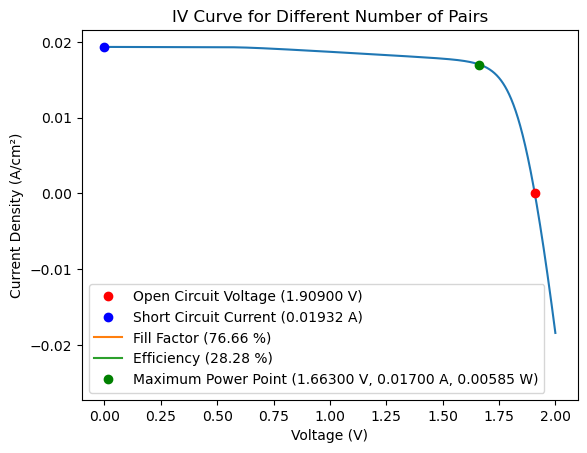

In [6]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
%time analysis = simulator.dc(V1=slice(0, 2, 0.001))
voltage = analysis.nodes['input'].as_ndarray()  # analysis: a dictionary of measured values from nodes and branches
current = analysis.branches['v1'].as_ndarray()  # as_ndarray: converts measured values from a specific node or branch into a numpy array
normalized_current = current / (w * l * M *N)

# Calculate open circuit voltage
v_oc_index = np.argmin(np.abs(normalized_current))  # abs: function that returns the absolute value of a given number
v_oc = voltage[v_oc_index]  # argmin: returns the index of the minimum element in the numpy array

# Calculate short circuit current
i_sc_index = np.argmin(np.abs(voltage))
i_sc = normalized_current[i_sc_index]

# Calculate Maximum Power Point
power = voltage * current
mpp_index = np.argmax(power)
v_mpp = voltage[mpp_index]
i_mpp = normalized_current[mpp_index]
max_power = power[mpp_index]
efficiency = (max_power/(0.1*w*l*M*N))*100

# Calculate Fill Factor
fill_factor = (v_mpp * i_mpp) / (v_oc * i_sc)

plt.plot(voltage, normalized_current)

plt.legend()
plt.xlabel('Voltage (V)')
plt.ylabel('Current Density (A/cm²)')
plt.title('IV Curve for Different Number of Pairs')

# 오픈 회로 전압과 단락 전류 표시
plt.plot(v_oc, 0, 'ro', label=f'Open Circuit Voltage ({v_oc:.5f} V)')
plt.plot(0, i_sc, 'bo', label=f'Short Circuit Current ({i_sc:.5f} A)')
plt.plot(0, -0.025, label=f'Fill Factor ({fill_factor*100:.2f} %)')
plt.plot(0, -0.02, label=f'Efficiency ({efficiency:.2f} %)')
# 최대 전력 지점 표시
plt.plot(v_mpp, i_mpp, 'go', label=f'Maximum Power Point ({v_mpp:.5f} V, {i_mpp:.5f} A, {max_power:.5f} W)')

plt.legend()

plt.show()